In [1]:
import sys                       
sys.path.append('../scripts/')
from ideal_robot import *
from scipy.stats import expon, norm ###spike_noise_header###

In [2]:
class Robot(IdealRobot):

    def __init__(self, pose, agent=None, sensor=None, color="black",
                 noise_per_meter=5, noise_std = math.pi/60): 
        super().__init__(pose, agent, sensor, color)
        self.noise_pdf = expon(scale = 1.0/(1e-100 + noise_per_meter))
        self.distance_until_noise = self.noise_pdf.rvs()
        self.theta_noise = norm(scale = noise_std)
        self.bias_rate_nu = norm.rvs(loc = 1.0,scale = bias_rate_stds[0])
        self.bias_rate_omega = norm.rvs(loc = 1.0,scale = bias_rate_stds[1])
        
    def bias(self,nu,omega):
        return nu * self.bias_rate_nu , omega * self.bias_rate_omega
        
    def noise(self, pose, nu, omega, time_interval):
        self.distance_until_noise -= abs(nu)*time_interval + self.r*abs(omega)*time_interval
        if self.distance_until_noise <= 0.0:
            self.distance_until_noise += self.noise_pdf.rvs() #瑣末だけど端数を残しておくために=でなく+=
            pose[2] += self.theta_noise.rvs()
            
        return pose

    def one_step(self, time_interval):
        if not self.agent: return        
        obs =self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.decision(obs)
        nu, omega = self.bias(nu,omega)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.pose = self.noise(self.pose, nu, omega, time_interval) #追加

<IPython.core.display.Javascript object>


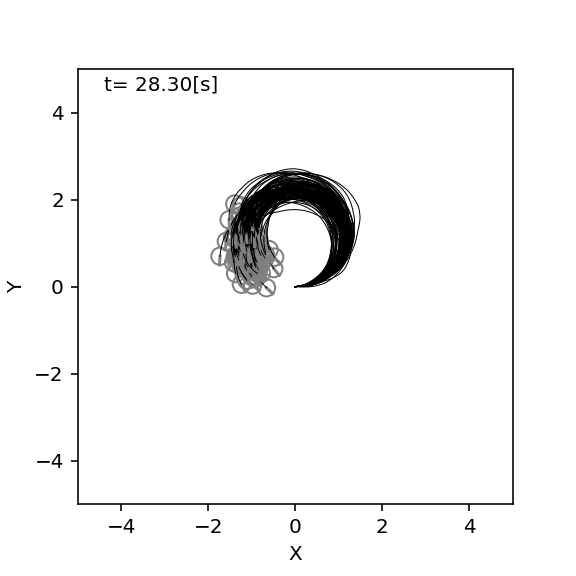

In [3]:
world = World(30, 0.1)   ###draw_spike_noise###

for i in range(100):
    circling = Agent(0.2, 10.0/180*math.pi)
    r = Robot( np.array([0, 0, 0]).T, sensor=None, agent=circling, color="gray" )  #灰色を指定
    world.append(r)

world.draw()